In [177]:
# import basic python packages
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import our steady state stress model
#from stress_equation_notorch import stress_equation_batch

# This our color scheme for plotting
plot_color = np.array(["#5B9BD5",  # Soft Blue
    "#A5D6A7",  # Soft Green
    "#F1C40F",  # Warm Yellow
    "#E74C3C",  # Muted Red
    "#9B59B6",  # Soft Purple
    "#F39C12",  # Orange
    "#1F77B4",  # Cool Blue
    "#BDC3C7"   # Light Gray
    ])

In [178]:
# Preprossing Part 1: Load Data and smoothen the stress-thickness curve

Data_raw = pd.read_csv('all_experiments.csv')
raw_temp_x = Data_raw['thickness'].to_numpy()
raw_temp_y = Data_raw['stressthickness'].to_numpy()

# beacuse the stress-thickness data is not a complex curve
# we can simplify it by an exponential criteria:
# minimum points: 5, maximum points: 12 (200 nm)
# for those larger than 200 nm, we just take add 1 additional point per 50 nm
# if the original data has less than 5 points, we just take all the points
def smoothen_STF_curve(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    x = np.asarray(x)
    y = np.asarray(y)

    thickness_range = x[-1] - x[0]

    # If too few points, keep them all
    if len(x) <= 5:
        return x, y

    # determine number of points based on thickness range
    if thickness_range <= 200:
        num_points = min(12, max(5, thickness_range // 10))
    else:
        num_points = 12 + (thickness_range - 200) // 50

    # Do not request more points than available
    num_points = int(min(num_points, len(x)))

    # Use float linspace, then round and uniquify indices
    idx = np.linspace(0, len(x) - 1, num_points)
    idx = np.round(idx).astype(int)
    idx = np.unique(idx)

    return x[idx], y[idx]


# we need to perfrom within each material, each group and each different growth rate, temperature or pressure
materials = Data_raw['material'].unique()
smoothed_x = np.array([])
smoothed_y = np.array([])

# we need to add back the other features to the new table with smoothed thickness and stressthickness
# so here we create an empty dataframe to store the new data
Data_simp = pd.DataFrame(columns=Data_raw.columns)

for mat in materials:

    mat_data = Data_raw[Data_raw['material'] == mat]
    groups = mat_data['data_source'].unique()

    for group in groups:

        group_data = mat_data[mat_data['data_source'] == group]
        growth_rates = group_data['R'].unique()
        
        for rate in growth_rates:

            rate_data = group_data[group_data['R'] == rate]
            temperatures = rate_data['T'].unique()
            for temp in temperatures:
                
                temp_data = rate_data[rate_data['T'] == temp]
                pressures = temp_data['P'].unique()
                for pres in pressures:

                    pres_data = temp_data[temp_data['P'] == pres]
                    x_vals = pres_data['thickness'].to_numpy()
                    y_vals = pres_data['stressthickness'].to_numpy()
                    sx, sy = smoothen_STF_curve(x_vals, y_vals)
                    smoothed_x = np.concatenate((smoothed_x, sx))
                    smoothed_y = np.concatenate((smoothed_y, sy))

                    # add back the other features to the new dataframe
                    temp_df = pres_data.iloc[np.searchsorted(x_vals, sx)].copy()
                    temp_df['thickness'] = sx
                    temp_df['stressthickness'] = sy
                    # output the information if the temp_df has NaN values
                    if temp_df.isnull().any().any():
                        print(f"Warning: temp_df has NaN values for material {mat}, R {rate}, T {temp}, P {pres}")
                    Data_simp = pd.concat([Data_simp, temp_df], ignore_index=True)

C:\Users\xjtut\AppData\Local\Temp\ipykernel_15260\2792061891.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Data_simp = pd.concat([Data_simp, temp_df], ignore_index=True)


In [179]:
Data = Data_simp.copy()
temp_x = Data['thickness'].to_numpy()
temp_y = Data['stressthickness'].to_numpy()
# for incremental stress calculation, we need to perform within each material 
# and each different groups, growth rate, temperature or pressure
temp_incremental_stress = np.zeros_like(temp_y)
unique_materials = Data['material'].unique()

for material in unique_materials:
    material_mask = Data['material'] == material   
    unique_group = Data.loc[material_mask, 'data_source'].unique()

    for group in unique_group:
        group_mask = material_mask & (Data['data_source'] == group)
        unique_R = Data.loc[group_mask, 'R'].unique()
   
        for R in unique_R:
            R_mask = group_mask & (Data['R'] == R)
            unique_P = Data.loc[R_mask, 'P'].unique()

            for P in unique_P:
                P_mask = R_mask & (Data['P'] == P)
                unique_T = Data.loc[P_mask, 'T'].unique()

                for T in unique_T:
                    T_mask = P_mask & (Data['T'] == T)
                    indices = np.where(T_mask)[0]
                    thickness_subset = temp_x[indices]
                    stressthickness_subset = temp_y[indices]
                    # sort by thickness
                    sorted_indices = np.argsort(thickness_subset)
                    thickness_sorted = thickness_subset[sorted_indices]
                    stressthickness_sorted = stressthickness_subset[sorted_indices]
                    # calculate incremental stress


                    incremental_stress_sorted = np.zeros_like(stressthickness_sorted)

                    if len(thickness_sorted) == 1:
                        # with only one point, derivative is basically undefined → pick 0 or np.nan
                        incremental_stress_sorted[0] = np.nan
                    else:
                        # forward difference for the *first* point
                        delta_stress_thickness = stressthickness_sorted[1] - stressthickness_sorted[0]
                        delta_thickness = thickness_sorted[1] - thickness_sorted[0]
                        incremental_stress_sorted[0] = delta_stress_thickness / delta_thickness

                        # usual backward difference for the rest
                        for i in range(1, len(thickness_sorted)):
                            delta_stress_thickness = stressthickness_sorted[i] - stressthickness_sorted[i-1]
                            delta_thickness = thickness_sorted[i] - thickness_sorted[i-1]
                            incremental_stress_sorted[i] = delta_stress_thickness / delta_thickness

                    # assign back to the original array
                    for idx, sorted_idx in zip(indices, sorted_indices):
                        temp_incremental_stress[idx] = incremental_stress_sorted[sorted_idx]

Data['incremental_stress'] = temp_incremental_stress
# set R to three digits precision, P to two digits precision, T to one digit precision
Data['R'] = Data['R'].round(3)
Data['P'] = Data['P'].round(2)
Data['T'] = Data['T'].astype(float).round(1)

In [180]:
hyper_Data = pd.read_csv('source.csv', encoding='latin1')
# set R to three digits precision, P to two digits precision, T to one digit precision
hyper_Data['R'] = hyper_Data['R'].round(3)
hyper_Data['P'] = hyper_Data['P'].round(2)
hyper_Data['T'] = hyper_Data['T'].round(1)
# merge hyperparameters into data based on material, data_source, R, P, T
Data = Data.merge(hyper_Data, on=['material', 'data_source', 'R', 'P', 'T'], how='inner')

In [181]:
# list all unique materials in the dataset
unique_materials_raw = Data_raw['material'].unique()
unique_materials = Data['material'].unique()

# find which materials are missing after merging
missing_materials = set(unique_materials_raw) - set(unique_materials)
if missing_materials:
    print("Materials missing after merging:", missing_materials)
# find all the conditions couples that has unique material, group, R, P, T in the raw data but missing after merging
raw_conditions = Data_raw[['material', 'data_source', 'R', 'P', 'T']].drop_duplicates()
merged_conditions = Data[['material', 'data_source', 'R', 'P', 'T']].drop_duplicates()
merged_set = set(tuple(row) for _, row in merged_conditions.iterrows())
if raw_conditions.shape[0] != len(merged_set):
    missing_conditions = []
    for _, row in raw_conditions.iterrows():
        condition_tuple = tuple(row)
        if condition_tuple not in merged_set:
            missing_conditions.append(condition_tuple)
            print("Conditions missing after merging:", condition_tuple,'\n')

    
print(raw_conditions.shape[0], "unique conditions in raw data"
      , len(merged_set), "unique conditions after merging")
# find which materials are not in the raw data but appear in the source.csv
unique_materials_source = hyper_Data['material'].unique()
extra_materials = set(unique_materials_source) - set(unique_materials)
if extra_materials:
    print("Extra materials after merging:", extra_materials)

Materials missing after merging: {nan}
Conditions missing after merging: (nan, nan, nan, nan, nan) 

241 unique conditions in raw data 240 unique conditions after merging
Extra materials after merging: {'Mo84Si16'}


In [182]:
# raw data visualization part
# visualize the smoothed incremental stress for selected materials
selected_materials = unique_materials
local_color_id = 0
for i, mat in enumerate(selected_materials):
    
    mat_data = Data[Data['material'] == mat]
    figure_id = i + 1
    plt.figure(figure_id, figsize=(10, 6))
    # iterate per distinct growth rate, temperature, pressure
    growth_rates = mat_data['R'].unique()
    for rate in growth_rates:
        rate_data = mat_data[mat_data['R'] == rate]
        temperatures = rate_data['T'].unique()
        for temp in temperatures:
            temp_data = rate_data[rate_data['T'] == temp]
            pressures = temp_data['P'].unique()
            for pres in pressures:
                pres_data = temp_data[temp_data['P'] == pres]
                # label with growth rate, temperature, pressure
                plt.scatter(pres_data['thickness'],pres_data['incremental_stress'], 
                    label=f'{mat} (R={rate}, T={temp}, P={pres}), {pres_data["data_source"].iloc[0]}', 
                    color=plot_color[local_color_id % len(plot_color)])
                local_color_id += 1

    plt.xlabel('Thickness (nm)')
    plt.ylabel('Incremental Stress (MPa)')
    plt.title(f'Incremental Stress vs Thickness for {mat} (R={rate}, T={temp}, P={pres})')
    plt.legend()
    plt.close()

In [183]:
# show all materials list, and for each material, show different groups
# create a json object to store the information
# materials as keys, groups as values
materials = Data['material'].unique()
materials_groups = {}
for mat in materials:
    mat_data = Data[Data['material'] == mat]
    groups = mat_data['data_source'].unique()
    materials_groups[mat] = groups.tolist()

print("Materials and their groups:")
for mat, groups in materials_groups.items():
    print(f"{mat}: {groups}")

Materials and their groups:
Ag: ['Abermann', 'Chason', 'Flototto', 'Koch', 'Seel', 'Shull']
Co: ['Pletea']
Cr-90W: ['Zhou']
Cr-33W: ['Su']
Cr-68W: ['Zhou']
Cr-25W: ['Su']
Cr-20W: ['Zhou']
Cr-6W: ['Zhou']
Cr-50W: ['Su']
Cr: ['Hoffman', 'Klokholm', 'Su', 'Thurner', 'Zhou']
Ag-80Cu: ['Kaub']
Cu-20Ni: ['Kaub']
Cu-20V: ['Kaub']
Cu-15Ni: ['Kaub']
Ag-90Cu: ['Kaub']
Cu-10Ni: ['Kaub']
Cu-10V: ['Kaub']
Ag-95Cu: ['Kaub']
Cu-5Ni: ['Kaub']
Cu-5V: ['Kaub']
Ag-97Cu: ['Kaub']
Cu-3V: ['Kaub']
Cu-1V: ['Kaub']
Cu: ['Kaub', 'Abermann', 'Chocyk', 'Pletea', 'Shull', 'Friesen', 'Winau']
Fe-86W: ['Zhou']
Fe-79Pt: ['Fu']
Fe-72Pt: ['Fu']
Fe-55Pt: ['Fu']
Fe-46Pt: ['Fu']
Fe-35Pt: ['Fu']
Fe-18Pt: ['Fu']
Fe-16Cr: ['Zhou']
Fe-8Cr: ['Zhou']
Fe-6Cr: ['Zhou']
Fe-4Cr: ['Zhou']
Fe-3Cr: ['Zhou']
Fe-3W: ['Zhou']
Fe: ['Fu', 'Thurner', 'Winau', 'Zhou']
V-75Mo: ['Su']
V-25Mo: ['Su']
V-50Mo: ['Su']
Mo: ['Fillon', 'Su']
Ni: ['Yu', 'Kaub', 'Koenig', 'Lumbeeck', 'Winau']
Pt: ['Fu']
Ti-80W: ['Kaub']
Ti-95W: ['Kaub']
Ti: ['Klokholm

In [184]:
# showing all disctinct group
materials = Data['data_source'].unique()
print("Distinct groups in the dataset:")
print(materials)

Distinct groups in the dataset:
['Abermann' 'Chason' 'Flototto' 'Koch' 'Seel' 'Shull' 'Pletea' 'Zhou' 'Su'
 'Hoffman' 'Klokholm' 'Thurner' 'Kaub' 'Chocyk' 'Friesen' 'Winau' 'Fu'
 'Fillon' 'Yu' 'Koenig' 'Lumbeeck' 'Scheeweis' 'Johnson']


In [185]:
# select certain materials or groups if needed
materails_to_use = ["V",'W','V-25W','V-33W','V-50W',
                    'Cr','Cr-25W','Cr-33W','Cr-50W',
                    'Mo','V-25Mo','V-50Mo','V-75Mo',
                    'Ag','Co','Ni','Cu',
					'Ti','Pt','Fe']
groups_to_use = None  # e.g., ['Su', 'Group2'], or None to use all groups


# Avoid passing None to isin(); when group_to_use is None, skip that filter
if groups_to_use is None:
	Data_to_use = Data[Data['material'].isin(materails_to_use)].copy()
else:
	Data_to_use = Data[
		(Data['material'].isin(materails_to_use)) &
		(Data['data_source'].isin(groups_to_use))
	].copy()

Y_label = 'stressthickness'  # 'incremental_stress' or 'stressthickness'
#target_y = Data_to_use['incremental_stress']
target_y = Data_to_use[Y_label]
input_X = Data_to_use[['R','P','T','thickness','Tm_K','data_source','Alloy_type','Crystal_Structure']]
#input_X = Data_to_use[['R','thickness','Tm_K']]

num_ftrs = ['R','P','T','thickness','Tm_K']
cat_ftrs = ['data_source','Alloy_type','Crystal_Structure']

#global_random_state = 2025
# split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(input_X, target_y, test_size=0.2, random_state=global_random_state)


In [186]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
#num_cols = input_X.select_dtypes(include=['int64', 'float64']).columns


# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs) 
    ]
)

In [187]:
from sklearn.dummy import DummyRegressor

baseline = DummyRegressor()

baseline_param_grid = {
    'model__strategy': ['mean', 'median']  # tune mean vs median
}

from sklearn.linear_model import ElasticNet

elastic = ElasticNet(random_state=0, max_iter=10000)

elastic_param_grid = {
    "model__alpha":    [0.001, 0.01, 0.1, 1.0, 10.0],
    "model__l1_ratio": [0.1, 0.5, 0.9],
}

from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=0)
#param_grid = {'model__n_estimators': [100, 200], 'model__learning_rate': [0.001, 0.01, 0.1]}
gbr_param_grid = {
    'model__n_estimators': [300,350,400,500],#np.arange(450, 470, 3),
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    #'model__max_depth': [2, 3, 4],
    #'model__subsample': [0.7, 1.0],
    #'model__min_samples_leaf': [1, 5],
    'model__n_iter_no_change': [20],
}

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_param_grid = {
    'model__max_features': ['sqrt', 'log2', None],
    'model__max_depth': [None, 5, 10, 15, 20, 25],
    #'model__n_estimators': [200, 500],
    #'model__min_samples_split': [2, 5],
    #'model__min_samples_leaf': [1, 2],
    #'model__max_features': ['sqrt', 'log2'],
}

from sklearn.svm import SVR

svr = SVR()

svr_param_grid = {
    'model__kernel': ['rbf'],
    'model__C': [1, 10, 100],
    #'model__epsilon': [0.01, 0.1],
    #'model__gamma': ['scale', 'auto'],
}

from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

knn_param_grid = {
    'model__n_neighbors': [3, 5, 10],
    'model__weights': ['uniform', 'distance'],
    #'model__p': [1, 2],  # 1 = Manhattan, 2 = Euclidean
}

In [188]:
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.model_selection import GroupKFold, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

def balanced_group_folds(groups: pd.Series, n_splits: int):
    groups = pd.Series(groups).reset_index(drop=True)
    uniq = groups.unique()

    # group sizes
    sizes = {g: (groups == g).sum() for g in uniq}
    # sort groups biggest first
    uniq_sorted = sorted(uniq, key=lambda g: sizes[g], reverse=True)

    fold_groups = [[] for _ in range(n_splits)]
    fold_sizes = [0] * n_splits

    for g in uniq_sorted:
        k = int(np.argmin(fold_sizes))
        fold_groups[k].append(g)
        fold_sizes[k] += sizes[g]

    outer_splits = []
    idx = np.arange(len(groups))
    for k in range(n_splits):
        test_mask = groups.isin(fold_groups[k]).values
        test_idx = idx[test_mask]
        train_idx = idx[~test_mask]
        outer_splits.append((train_idx, test_idx))
    return outer_splits

def MLpipe_KFold_RMSE_Group(
    X,
    y,
    preprocessor,
    ML_algo,
    param_grid,
    groups,
    split_mode="material",       # "material" or "R_with_coverage"
    material_series=None,        # needed when split_mode="R_with_coverage"
    n_splits=10,
    test_size=0.1,
    optimize_by="rmse",          # "rmse" or "r2"
):
    """
    Nested CV with group-aware outer split and standard KFold inner CV.

    Outer CV
    --------
    - split_mode='material':
        GroupKFold by `groups` (typically material). Each group appears in
        exactly one test fold.
    - split_mode='R_with_coverage':
        GroupShuffleSplit by `groups` (e.g. R), but enforce that every
        (material, group) pair appears in at least one test set
        (approximate coverage loop).

        In your current use:
            groups         = X['R']
            material_series= Data_to_use['material']
        so coverage is over all (material, R) pairs.

    Inner CV
    --------
    - Hyperparameter tuning via GridSearchCV on the training part of each
      outer split.
    - `optimize_by` controls the scoring metric:
        * "rmse": scoring='neg_root_mean_squared_error'
        * "r2":   scoring='r2'

    Returns
    -------
    test_rmse_scores : list[float]
    best_models : list[Pipeline]
    best_y_pred : pd.Series
    best_y_train_pred : pd.Series
    oof_pred : pd.Series
    test_r2_scores : list[float]
    best_test_r2 : float
    oof_r2 : float
    """

    # Copy to avoid mutating caller’s objects
    X = X.copy()
    y = y.copy()
    groups = pd.Series(groups).reset_index(drop=True)

    if material_series is None:
        material_series = pd.Series(["_dummy"] * len(X))
    else:
        material_series = pd.Series(material_series).reset_index(drop=True)

    # ---- choose inner scoring metric ----
    if optimize_by == "rmse":
        inner_scoring = "neg_root_mean_squared_error"
    elif optimize_by == "r2":
        inner_scoring = "r2"
    else:
        raise ValueError("optimize_by must be 'rmse' or 'r2'")

    # ---- build outer splits depending on mode ----
    outer_splits = []

    if split_mode == "material":
        gkf = GroupKFold(n_splits=min(n_splits, groups.nunique()))
        for train_idx, test_idx in gkf.split(X, y, groups=groups):
            outer_splits.append((train_idx, test_idx))

    elif split_mode == "R_with_coverage":
        # Disjoint outer folds by R (true OOF; no overlap)
        # gkf = GroupKFold(n_splits=min(n_splits, groups.nunique()))
        # outer_splits = list(gkf.split(X, y, groups=groups))
        outer_splits = balanced_group_folds(groups, n_splits=min(n_splits, groups.nunique()))
        print(f"Outer CV: GroupKFold by R with {len(outer_splits)} disjoint folds.")


    else:
        raise ValueError(f"Unknown split_mode={split_mode!r}. Use 'material' or 'R_with_coverage'.")

    # ---- actual CV loop over outer splits ----
    test_rmse_scores = []
    test_r2_scores = []
    best_models = []

    # global-best model tracking (according to optimize_by)
    best_selection_score = None
    best_y_pred = None
    best_y_train_pred = None
    best_test_r2 = None

    # out-of-fold predictions over the full dataset
    oof_pred = pd.Series(index=y.index, dtype=float)

    for fold_idx, (train_idx, test_idx) in enumerate(outer_splits):
        x_train, x_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', ML_algo),
        ])

        inner_cv = KFold(
            n_splits=4,
            shuffle=True,
            random_state=1830 + fold_idx,
        )

        grid_search = GridSearchCV(
            pipe,
            param_grid=param_grid,
            cv=inner_cv,
            scoring=inner_scoring,  # RMSE or R2
            n_jobs=-1,
        )
        grid_search.fit(x_train, y_train)

        best_model = grid_search.best_estimator_

        rng = np.random.RandomState(2025 + fold_idx)  # fold-specific but reproducible
        random_seeds = rng.choice(np.arange(1830, 1931), size=10, replace=False)

        seed_rmses = []
        seed_r2s = []
        y_test_pred_fixed = None  # fixed-seed prediction for OOF (no test-based selection)

        fixed_seed = int(random_seeds[0])

        for seed in random_seeds:
            model_seed = clone(best_model)

            # only set if supported (won't crash for deterministic models)
            if "model__random_state" in model_seed.get_params():
                model_seed.set_params(model__random_state=int(seed))

            model_seed.fit(x_train, y_train)
            y_test_pred_seed = model_seed.predict(x_test)

            seed_rmses.append(np.sqrt(mean_squared_error(y_test, y_test_pred_seed)))
            seed_r2s.append(r2_score(y_test, y_test_pred_seed))

            if int(seed) == fixed_seed:
                y_test_pred_fixed = y_test_pred_seed

        # use mean across seeds as fold metric (captures non-determinism)
        test_rmse = float(np.mean(seed_rmses))
        test_r2 = float(np.mean(seed_r2s))

        # (optional) print seed variability per fold (helps debugging / report)
        seed_rmse_std = float(np.std(seed_rmses, ddof=1))
        seed_r2_std = float(np.std(seed_r2s, ddof=1))
        if y_test_pred_fixed is None:
            y_test_pred_fixed = y_test_pred_seed

        # compute SST/SSE using the fixed-seed prediction (for your warning print)
        y_test_pred_raw = y_test_pred_fixed
        sst = np.sum((y_test - y_test.mean())**2)
        sse = np.sum((y_test - y_test_pred_raw)**2)
        if sse > sst:
            print("WARNING: Fold", fold_idx, "SSE > SST; R2 may be negative.")
            print(f"fold {fold_idx:02d}  n={len(y_test):4d}  y_std={y_test.std():.4g}  "
                f"SST={sst:.4g}  SSE={sse:.4g}  R2_fixed={r2_score(y_test, y_test_pred_raw):.3f}  "
                f"R2_mean={test_r2:.3f}±{seed_r2_std:.3f}")

        # OOF must be from a fixed seed (avoid picking best seed on test set)
        oof_pred.iloc[test_idx] = y_test_pred_raw

        # store ONE representative fitted model (fixed seed) for later importance/SHAP
        # (so results[name]["best_models"] still works)
        best_model_fixed = clone(best_model)
        if "model__random_state" in best_model_fixed.get_params():
            best_model_fixed.set_params(model__random_state=fixed_seed)
        best_model_fixed.fit(x_train, y_train)

        best_model = best_model_fixed


        # decide whether this fold's model is the "global best"
        if optimize_by == "rmse":
            sel_score = test_rmse          # smaller is better
            is_better = (best_selection_score is None) or (sel_score < best_selection_score)
        else:  # optimize_by == "r2"
            sel_score = test_r2            # larger is better
            is_better = (best_selection_score is None) or (sel_score > best_selection_score)

        if is_better:
            best_selection_score = sel_score
            best_test_r2 = test_r2

            y_train_pred_raw = best_model.predict(x_train)
            best_y_pred = pd.Series(
                y_test_pred_raw,
                index=y_test.index,
                name='y_pred',
            )
            best_y_train_pred = pd.Series(
                y_train_pred_raw,
                index=y_train.index,
                name='y_train_pred',
            )

        test_rmse_scores.append(test_rmse)
        test_r2_scores.append(test_r2)
        best_models.append(best_model)

    # ---- compute overall OOF R² (ignoring rows w/o predictions) ----
    mask = oof_pred.notna()
    if mask.sum() == 0:
        oof_r2 = np.nan
        print("WARNING: no out-of-fold predictions, OOF R2 set to NaN.")
    else:
        oof_r2 = r2_score(y[mask], oof_pred[mask])

    return (
        test_rmse_scores,
        best_models,
        best_y_pred,
        best_y_train_pred,
        oof_pred,
        test_r2_scores,
        best_test_r2,
        oof_r2,
    )


In [189]:
model_spaces = {
    "BaselineDummy": (baseline, baseline_param_grid),
    "Elastic Net": (elastic, elastic_param_grid),
    "GradientBoosting": (gbr, gbr_param_grid),
    "RandomForest": (rf, rf_param_grid),
    # "HistGB": (hgb, hgb_param_grid),
    "SVR": (svr, svr_param_grid),
    "KNN": (knn, knn_param_grid),
}

results = {}

for name, (algo, grid) in model_spaces.items():
    print(f"\n=== Running model: {name} (R groups, coverage on materials) ===")
    test_scores, best_models, best_y_pred, best_y_train_pred, oof_pred, test_r2_scores, best_test_r2, oof_r2 = MLpipe_KFold_RMSE_Group(
        input_X,
        target_y,
        preprocessor,
        ML_algo=algo,
        param_grid=grid,
        groups=input_X['R'],                 # "R" or 'Tm_K'
        split_mode="R_with_coverage",        # "material" or "R_with_coverage"
        material_series=Data_to_use['material'],  # we want coverage at material level
        n_splits=10,
        test_size=0.1,
        optimize_by="r2"
    )

    results[name] = {
    "test_scores": test_scores,          # RMSE per fold
    "best_models": best_models,
    "best_y_pred": best_y_pred,
    "best_y_train_pred": best_y_train_pred,
    "oof_pred": oof_pred,
    "test_r2_scores": test_r2_scores,   
    "best_test_r2": best_test_r2,
    "oof_r2": oof_r2,
}

    print(f"{name} mean RMSE: {np.mean(test_scores):.4f} ± {np.std(test_scores):.4f}")
    print("Best-fold R2 (for RMSE-best model):", best_test_r2)
    print("OOF R2:", oof_r2)




=== Running model: BaselineDummy (R groups, coverage on materials) ===
Outer CV: GroupKFold by R with 10 disjoint folds.
fold 00  n= 240  y_std=217.7  SST=1.133e+07  SSE=1.208e+07  R2_fixed=-0.067  R2_mean=-0.067±0.000
fold 01  n= 214  y_std=210.9  SST=9.475e+06  SSE=1.079e+07  R2_fixed=-0.139  R2_mean=-0.139±0.000
fold 02  n= 217  y_std=214.9  SST=9.975e+06  SSE=1.006e+07  R2_fixed=-0.008  R2_mean=-0.008±0.000
fold 03  n= 217  y_std=131  SST=3.709e+06  SSE=3.833e+06  R2_fixed=-0.034  R2_mean=-0.034±0.000
fold 04  n= 213  y_std=107.8  SST=2.465e+06  SSE=2.631e+06  R2_fixed=-0.067  R2_mean=-0.067±0.000
fold 05  n= 213  y_std=112.2  SST=2.668e+06  SSE=2.8e+06  R2_fixed=-0.050  R2_mean=-0.050±0.000
fold 06  n= 217  y_std=163.4  SST=5.767e+06  SSE=5.907e+06  R2_fixed=-0.024  R2_mean=-0.024±0.000
fold 07  n= 215  y_std=158.3  SST=5.362e+06  SSE=5.421e+06  R2_fixed=-0.011  R2_mean=-0.011±0.000
fold 08  n= 215  y_std=177.2  SST=6.721e+06  SSE=6.87e+06  R2_fixed=-0.022  R2_mean=-0.022±0.000
f

In [190]:
for algo_name, res in results.items():
    scores = np.array(res["test_scores"])
    models = res["best_models"]

    # best run for this algorithm
    best_idx = int(np.argmin(scores))
    best_pipe = models[best_idx]
    est = best_pipe.named_steps["model"]
    est_params = est.get_params()

    # focus on the 2 “important” hyper-parameters per slide
    if isinstance(est, GradientBoostingRegressor):
        focus = {k: est_params[k] for k in ["learning_rate", "n_estimators"]
                 if k in est_params}
    elif isinstance(est, RandomForestRegressor):
        focus = {k: est_params[k] for k in ["max_depth", "max_features"]
                 if k in est_params}
    elif isinstance(est, ElasticNet):
        focus = {k: est_params[k] for k in ["alpha", "l1_ratio"]
                 if k in est_params}
    else:
        # fallback: print everything
        focus = est_params

    print(f"\n=== {algo_name} ===")
    print("mean test score over runs:", scores.mean())
    print("best test score:", scores[best_idx])
    print("best focused hyper-params:", focus)




=== BaselineDummy ===
mean test score over runs: 180.42813455191632
best test score: 111.13365493875126
best focused hyper-params: {'constant': None, 'quantile': None, 'strategy': 'mean'}

=== Elastic Net ===
mean test score over runs: 148.037252592763
best test score: 89.69645085590074
best focused hyper-params: {'alpha': 0.001, 'l1_ratio': 0.5}

=== GradientBoosting ===
mean test score over runs: 73.47402426303233
best test score: 36.41118011795299
best focused hyper-params: {'learning_rate': 0.2, 'n_estimators': 400}

=== RandomForest ===
mean test score over runs: 63.00810931377032
best test score: 36.8914853525682
best focused hyper-params: {'max_depth': 15, 'max_features': None}

=== SVR ===
mean test score over runs: 103.90738979348426
best test score: 62.18475431191949
best focused hyper-params: {'C': 100, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

=== KNN 

In [191]:
# pick best algorithm by mean RMSE
best_algo_name = min(results.keys(), key=lambda k: np.mean(results[k]["test_scores"]))
print("Best algorithm:", best_algo_name)

best_algo_models = results[best_algo_name]["best_models"]
best_algo_scores = results[best_algo_name]["test_scores"]

# best run index within that algorithm
best_run_idx = int(np.argmin(best_algo_scores))
best_pipe = best_algo_models[best_run_idx]  # Pipeline

print("Best overall model:", best_pipe)
print("Best underlying estimator:", best_pipe.named_steps["model"])
print("Estimator params:", best_pipe.named_steps["model"].get_params())


Best algorithm: RandomForest
Best overall model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['R', 'P', 'T', 'thickness',
                                                   'Tm_K']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                               

In [192]:
summary_rows = []
for name, res in results.items():
    scores = np.array(res["test_scores"])
    summary_rows.append({
        "model": name,
        "mean_RMSE": scores.mean(),
        "std_RMSE": scores.std(),
        "min_RMSE": scores.min(),
        "max_RMSE": scores.max(),
    })

summary_df = pd.DataFrame(summary_rows).sort_values("mean_RMSE")
print(summary_df.to_string(index=False))

# Save for easy copy into PPT/table
summary_df.to_csv("model_cv_summary.csv", index=False)

           model  mean_RMSE  std_RMSE   min_RMSE   max_RMSE
    RandomForest  63.008109 34.417649  36.891485 157.004468
GradientBoosting  73.474024 39.055240  36.411180 180.678621
             SVR 103.907390 30.839270  62.184754 162.247524
             KNN 112.727976 34.130603  60.062484 171.835760
     Elastic Net 148.037253 32.088688  89.696451 209.465077
   BaselineDummy 180.428135 51.841682 111.133655 278.868785


Skipping R2 plot for BaselineDummy
R2 scores: [-0.06669722594983463, -0.13863993871931224, -0.008281878801429832, -0.03363256703138573, -0.06732469324542523, -0.04955163344684177, -0.024249292448389914, -0.010984653531166622, -0.02222054100786508, -0.24677240983845694]
Skipping R2 plot for Elastic Net
R2 scores: [0.38174048935300153, 0.3543253221677446, 0.47339554993715866, 0.15772913763188248, -0.11090906611592555, 0.35772367181311904, 0.05423031792143218, 0.1297107476769744, 0.3132563190256805, 0.29658661895780297]


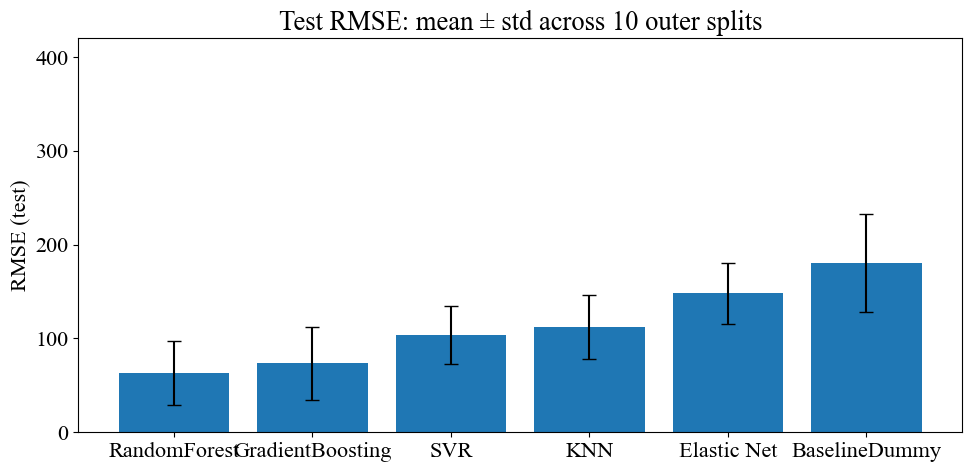

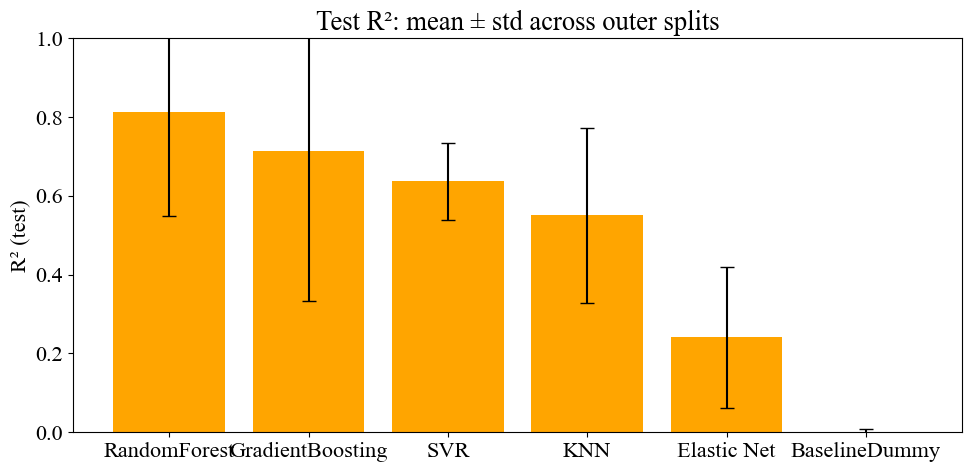

In [193]:
# set default font style to be new times new roman
plt.rcParams["font.family"] = "Times New Roman"
# set default font size to 14
plt.rcParams["font.size"] = 16

plt.figure(figsize=(10, 5))
plt.bar(summary_df["model"], summary_df["mean_RMSE"],
        yerr=summary_df["std_RMSE"], capsize=5)
plt.ylabel("RMSE (test)")
plt.ylim(0, 420)
plt.title("Test RMSE: mean ± std across 10 outer splits")
#plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("figures/rmse_barplot_models.png", dpi=300)
#plt.close()

# plot R2 scores as well
plt.figure(figsize=(10, 5))

models, r2_means, r2_stds = [], [], []

for name, res in results.items():
    if name in ["BaselineDummy", "Elastic Net"]:
        print("Skipping R2 plot for", name)
        print("R2 scores:", res["test_r2_scores"])
        #continue

    r2_scores = np.asarray(res["test_r2_scores"], dtype=float)
    models.append(name)
    r2_means.append(r2_scores.mean())
    r2_stds.append(r2_scores.std(ddof=1))  

order = np.argsort(r2_means)[::-1]
models   = [models[i] for i in order]
r2_means = [r2_means[i] for i in order]
r2_stds  = [r2_stds[i] for i in order]

plt.bar(models, r2_means, yerr=r2_stds, capsize=5, color="orange")
plt.ylabel("R² (test)")
plt.title("Test R²: mean ± std across outer splits")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("figures/r2_barplot_models.png", dpi=300)



In [194]:
# choose best algo and best outer fold as you already do
best_algo_models = results[best_algo_name]["best_models"]
best_algo_scores = results[best_algo_name]["test_scores"]
best_run_idx = int(np.argmin(best_algo_scores))  # or argmax R2 if you prefer
best_pipe = best_algo_models[best_run_idx]

# retrain on ALL data with those hyperparameters
best_pipe.fit(input_X, target_y)
y_pred_full = pd.Series(best_pipe.predict(input_X), index=target_y.index)

# then for plotting:
y_pred = y_pred_full   # instead of oof_pred




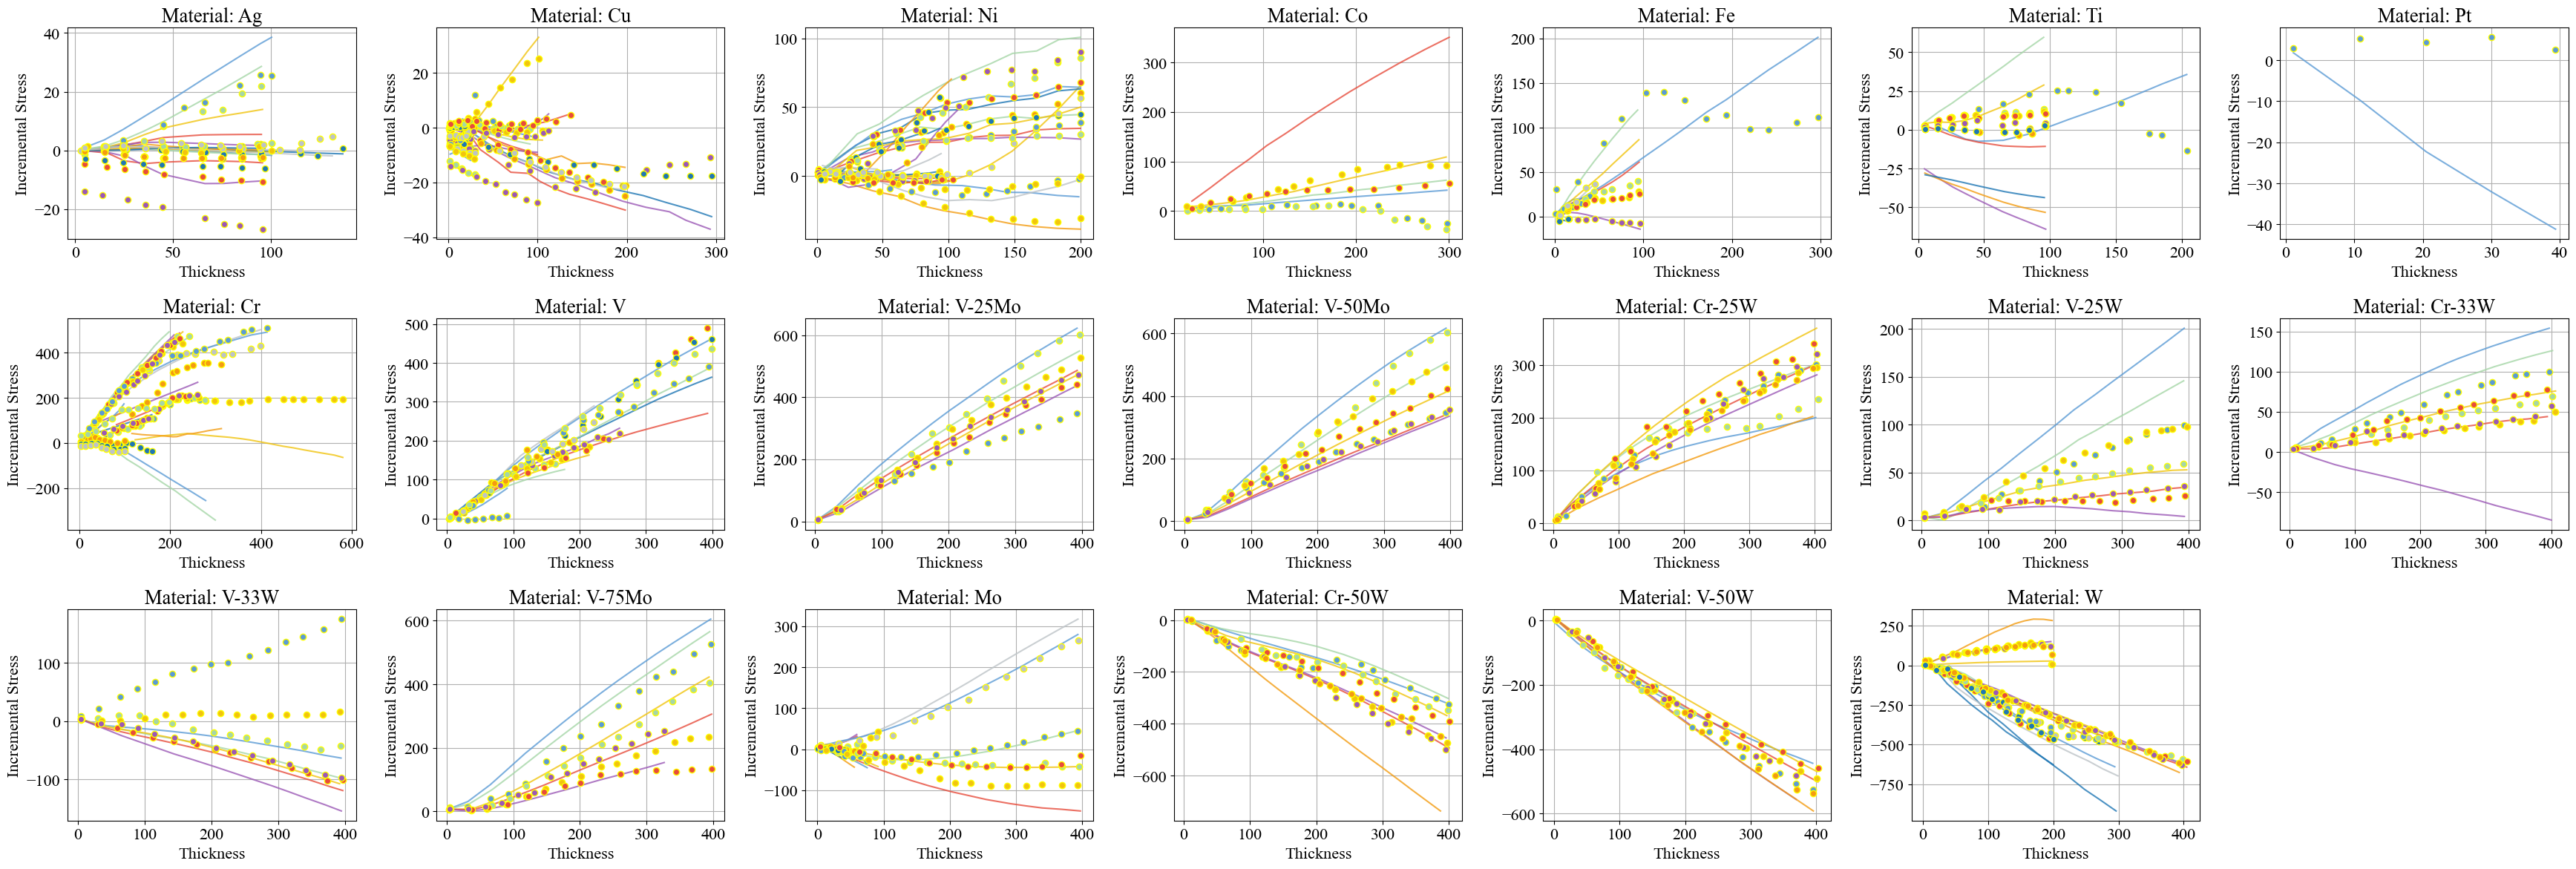

In [195]:
# visualize prediction vs actual
# we plot the whole dataset, but for test set we use yellow dots

# first plot the raw data in Data, group by material into different subplots, 
# then separate different groups, then growth rates, pressure, temperature

# find number of all unique materials, group, growth rate, temperature, pressure 

y_pred = results[best_algo_name]["oof_pred"] # best_y_pred or oof_pred

# Compute one Tm_K per material (mean/first – should be the same within a material)
material_Tm = (
    Data_to_use
    .groupby('material')['Tm_K']
    .first()              # or .mean()
    .dropna()             # in case some materials are missing Tm_K
)

# Sort materials by Tm_K
materials = material_Tm.sort_values().index

n_materials = len(materials)

# choose subplot layout: at most 3 columns
ncols = 7
nrows = int(np.ceil(n_materials / ncols))

plt.figure(figsize=(5 * ncols, 4 * nrows))

for i, material in enumerate(materials):
    # one subplot per material
    plt.subplot(nrows, ncols, i + 1)

    material_data = Data_to_use[Data_to_use['material'] == material]
    groups = material_data['data_source'].unique()

    plot_color_id = 0

    for G in groups:
        subset = material_data[material_data['data_source'] == G]
        growth_rates = subset['R'].unique()

        for rate in growth_rates:
            rate_subset = subset[subset['R'] == rate]
            temperatures = rate_subset['T'].unique()

            for temp in temperatures:
                temp_subset = rate_subset[rate_subset['T'] == temp]
                pressures = temp_subset['P'].unique()
                for pres in pressures:
                    pres_subset = temp_subset[temp_subset['P'] == pres]

                    # --- always plot the full raw curve for this (G,R,T,P) ---
                    full_thickness = pres_subset['thickness']
                    full_y = pres_subset[Y_label]

                    plt.plot(
                        full_thickness,
                        full_y,
                        color=plot_color[plot_color_id % len(plot_color)],
                        label=f'G={G}, R={rate}, T={temp}, P={pres}',
                        alpha=0.8,
                    )

                    # --- overlay OOF predictions only where we actually have them ---
                    if y_pred is not None:
                        valid_pred = y_pred.dropna()
                        pred_idx = pres_subset.index.intersection(valid_pred.index)

                        if len(pred_idx) > 0:
                            plt.scatter(
                                pres_subset.loc[pred_idx, 'thickness'],
                                valid_pred.loc[pred_idx],
                                color=plot_color[plot_color_id % len(plot_color)],
                                edgecolor='yellow',
                                marker='o',
                                zorder=5,
                            )

                    plot_color_id += 1

                    # show the condition for V-25W, all the R, T, P values
                    #if material == 'V-25W':
                    #    print(f'V-25W condition: G={G}, R={rate}, T={temp}, P={pres}')
                    #    print(valid_pred.loc[pred_idx])



    plt.title(f'Material: {material}')
    plt.xlabel('Thickness')
    plt.ylabel('Incremental Stress')
    #plt.legend(fontsize=8)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True)

plt.tight_layout()
plt.savefig("figures/pred_vs_actual_by_material.png", dpi=300)



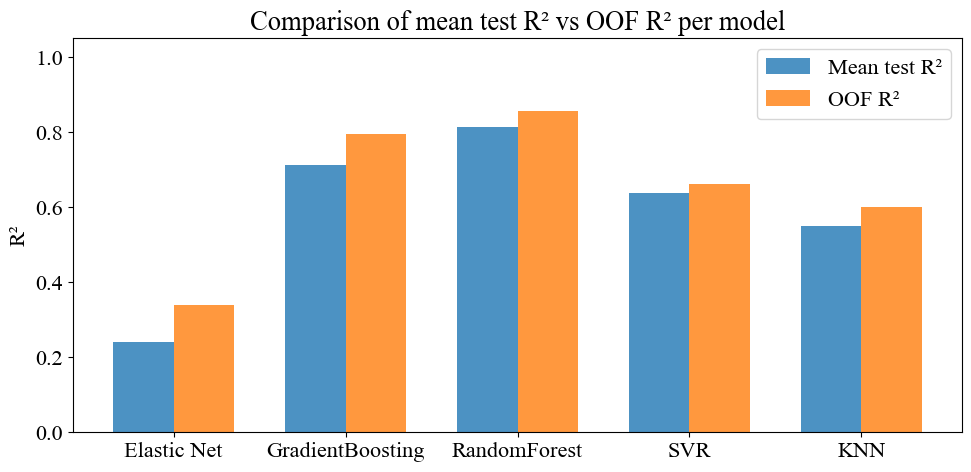

In [ ]:
# skip baseline model for clarity
models = [m for m in results.keys() if m != "BaselineDummy"]

mean_test_r2_vals = []
oof_r2_vals       = []

for m in models:
    # mean test R² across outer splits
    r2_scores = np.array(results[m]["test_r2_scores"], dtype=float)
    mean_test_r2_vals.append(r2_scores.mean())
    
    # already-aggregated OOF R²
    oof_r2_vals.append(float(results[m]["oof_r2"]))

mean_test_r2_vals = np.array(mean_test_r2_vals, dtype=float)
oof_r2_vals       = np.array(oof_r2_vals, dtype=float)

x = np.arange(len(models))
width = 0.35  # bar width

plt.figure(figsize=(10, 5))

# Mean test R² (left bar)
plt.bar(x - width/2, mean_test_r2_vals,
        width=width,
        label="Mean test R²",
        alpha=0.8)

# OOF R² (right bar)
plt.bar(x + width/2, oof_r2_vals,
        width=width,
        label="OOF R²",
        alpha=0.8)

plt.xticks(x, models)
plt.ylabel("R²")
plt.title("Comparison of mean test R² vs OOF R² per model")
plt.ylim(0, 1.05)  # or lower if some R² are negative
plt.legend()
plt.tight_layout()
plt.savefig("figures/r2_comparison_barplot.png", dpi=300)
plt.show()



Top 10 important features:
Tm_K: 1.8728466783993016
thickness: 0.6407393147597862
data_source: 0.27547527461048255
Crystal_Structure: 0.09371036287616341
R: 0.08785617662900977
P: 0.04524001514670821
Alloy_type: 0.0124413357383367
T: 0.008462786517993015


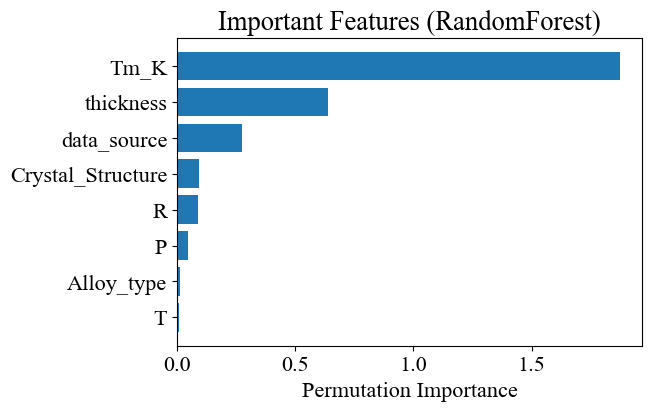

In [197]:
# use permutation importance to rank feature importance
from sklearn.inspection import permutation_importance
best_models = results[best_algo_name]["best_models"]
result = permutation_importance(best_models[-1], input_X, target_y, n_repeats=10, random_state=2025, n_jobs=-1)
importances = result.importances_mean

indices = np.argsort(importances)[-10:][::-1]
feature_names = input_X.columns
print("Top 10 important features:")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]}")

import matplotlib.pyplot as plt
top_features = [feature_names[i] for i in indices]
top_importances = [importances[i] for i in indices]

plt.figure(figsize=(6,4))
plt.barh(top_features, top_importances)
plt.xlabel("Permutation Importance")
plt.title(f"Important Features ({best_algo_name})")
plt.gca().invert_yaxis()
plt.savefig("figures/feature_importance.png", dpi=300)
plt.show()



In [198]:
import shap

best_models = results[best_algo_name]["best_models"]
best_model = best_models[-1]  # same one you used for permutation importance

# Split pipeline into preprocessor + tree model
pre = best_model.named_steps["preprocessor"]
tree_model = best_model.named_steps["model"]  # RandomForestRegressor or GradientBoostingRegressor

# Background sample (keep it small-ish)
if len(input_X) > 500:
    X_bg = input_X.sample(n=500, random_state=2025)
else:
    X_bg = input_X

# Transform to numeric feature space
X_bg_num = pre.transform(X_bg)  # numpy array

# TreeExplainer works directly on tree-based regressors
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_bg_num)   # shape: (n_samples, n_transformed_features)

# Mean |SHAP| per transformed feature
mean_abs = np.abs(shap_values).mean(axis=0)
mean_abs = np.array(mean_abs).ravel()


Top 10 features by mean(|SHAP|):
Tm_K: 94.8841
thickness: 43.1532
data_source: 39.3320
R: 14.7075
Crystal_Structure: 8.5548
P: 7.8589
Alloy_type: 3.5081
T: 3.2092


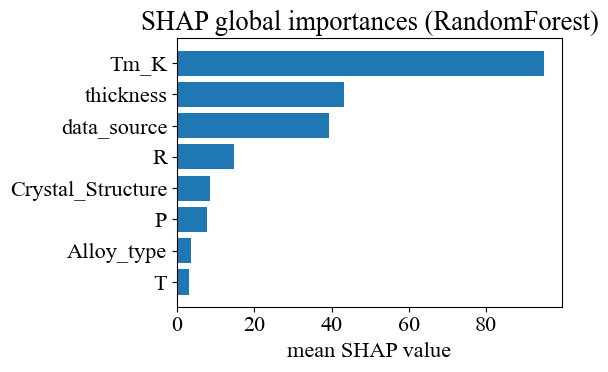

In [199]:
# Original feature lists
num_features = ['R', 'P', 'T', 'thickness', 'Tm_K']
cat_features = ['data_source', 'Alloy_type', 'Crystal_Structure']

# Get the fitted one-hot encoder to know how many columns per categorical feature
cat_pipeline = pre.named_transformers_['cat']
ohe = cat_pipeline.named_steps['onehot']

feat_names_agg = []
feat_importances_agg = []

idx = 0

# Numeric features: one column each
for f in num_features:
    feat_names_agg.append(f)
    feat_importances_agg.append(mean_abs[idx])
    idx += 1

# Categorical: sum |SHAP| across all one-hot columns belonging to each original feature
for orig, cats in zip(cat_features, ohe.categories_):
    n_cols = len(cats)
    feat_names_agg.append(orig)
    feat_importances_agg.append(mean_abs[idx:idx + n_cols].sum())
    idx += n_cols

feat_names_agg = np.array(feat_names_agg)
feat_importances_agg = np.array(feat_importances_agg)

# Top 10 by mean(|SHAP|)
indices = np.argsort(feat_importances_agg)[-10:][::-1]
top_features = feat_names_agg[indices]
top_importances = feat_importances_agg[indices]

print("Top 10 features by mean(|SHAP|):")
for f, val in zip(top_features, top_importances):
    print(f"{f}: {val:.4f}")

plt.figure(figsize=(6, 4))
plt.barh(top_features, top_importances)
plt.xlabel("mean SHAP value")
plt.title(f"SHAP global importances ({best_algo_name})")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("figures/shap_feature_importance.png", dpi=300)
plt.show()



Top grouped impurity-based feature importances:
Tm_K: 0.451739
thickness: 0.311129
data_source: 0.100557
R: 0.052475
crystal_structure: 0.041119
P: 0.031063
T: 0.006014
alloy_type: 0.005904


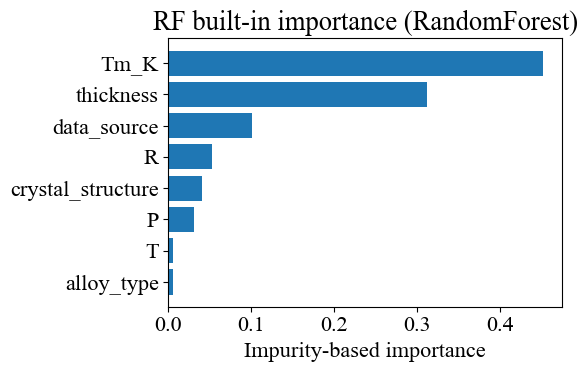

In [200]:
tree_name = "RandomForest"  
pipe = results[tree_name]["best_models"][-1]
est = pipe.named_steps["model"]
importances = est.feature_importances_
feat_names = pipe.named_steps["preprocessor"].get_feature_names_out()

feat_names = np.array([n.split("__", 1)[-1] for n in feat_names], dtype=str)

feat_group = []
for n in feat_names:
    if n.startswith("data_source_"):
        feat_group.append("data_source")
    elif n.startswith("Alloy_type_"):
        feat_group.append("alloy_type")
    elif n.startswith("Crystal_Structure_"):
        feat_group.append("crystal_structure")
    else:
        feat_group.append(n)
     
feat_group = np.array(feat_group, dtype=str)
imp_df = pd.DataFrame({"feature": feat_group, "importance": importances})

imp_grouped = (imp_df.groupby("feature", as_index=False)["importance"]
               .sum()
               .sort_values("importance", ascending=False))

k = 10
top = imp_grouped.head(k).iloc[::-1] 

print("Top grouped impurity-based feature importances:")
for f, v in zip(imp_grouped["feature"].head(k), imp_grouped["importance"].head(k)):
    print(f"{f}: {v:.6f}")

plt.figure(figsize=(6, 4))
plt.barh(top["feature"], top["importance"])
plt.xlabel("Impurity-based importance")
plt.title(f"RF built-in importance ({best_algo_name})")
plt.tight_layout()
plt.savefig("figures/impurity_feature_importance.png", dpi=300)

plt.show()


Example index: 0
Example data (original features):
R                               0.1
P                               0.0
T                             300.0
thickness                  4.515358
Tm_K                        1234.93
data_source                Abermann
Alloy_type           Single element
Crystal_Structure               FCC
Name: 0, dtype: object
Top 10 local SHAP contributions for this sample:
thickness: -24.1970
Tm_K: -13.0315
data_source=Su: 10.7679
R: -6.5635
Crystal_Structure=BCC: 2.8749
T: 1.4387
P: -0.7602
Alloy_type=Solid solution: 0.5520
Crystal_Structure=A15: -0.5225
Alloy_type=Single element: 0.4238


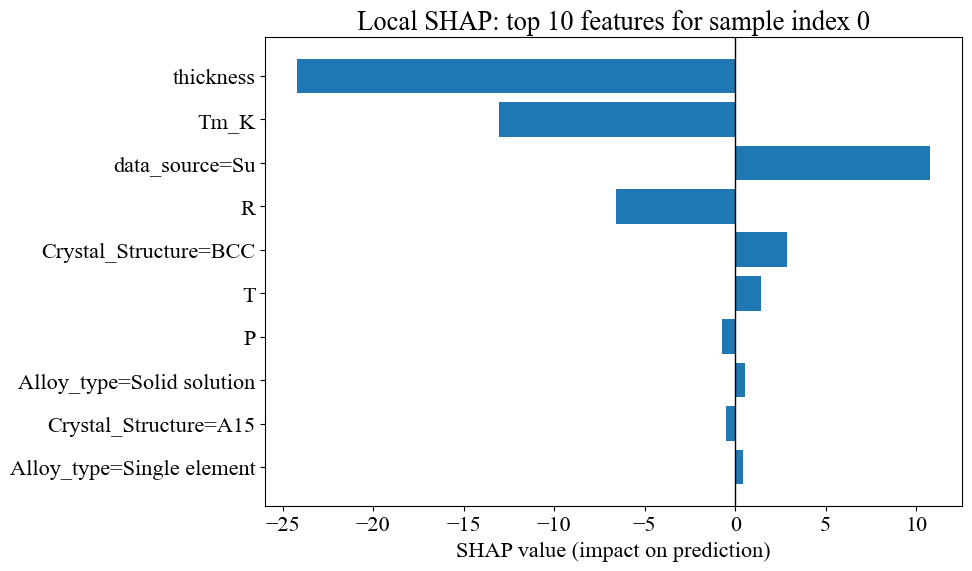

In [201]:
transformed_feature_names = []

# Numeric
transformed_feature_names.extend(num_features)

# Categorical (one-hot)
for orig, cats in zip(cat_features, ohe.categories_):
    for cat in cats:
        transformed_feature_names.append(f"{orig}={cat}")

# choose one example to explain
example_idx = 0  # change to any row index you like
# print the example data information, 
print("Example index:", example_idx)
print("Example data (original features):")
print(input_X.iloc[example_idx])

x_example_orig = X_bg.iloc[[example_idx]]      # original features (1 row, DataFrame)
x_example_num  = pre.transform(x_example_orig) # transformed to numeric array

# SHAP values for this single sample (shape: (1, n_transformed_features))
shap_vals_example = explainer.shap_values(x_example_num)[0]  # 1D array

# sort features by |SHAP| for this sample, take top 10
idx_sorted = np.argsort(np.abs(shap_vals_example))[-10:][::-1]

local_feat_names = np.array(transformed_feature_names)[idx_sorted]
local_shap_vals  = shap_vals_example[idx_sorted]

# Print them
print("Top 10 local SHAP contributions for this sample:")
for f, v in zip(local_feat_names, local_shap_vals):
    print(f"{f}: {v:.4f}")

# Bar plot (positive = pushes prediction up, negative = down)
plt.figure(figsize=(10, 6))
plt.barh(local_feat_names, local_shap_vals)
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("SHAP value (impact on prediction)")
plt.title(f"Local SHAP: top 10 features for sample index {example_idx}")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("figures/local_shap_example.png", dpi=300)
plt.show()



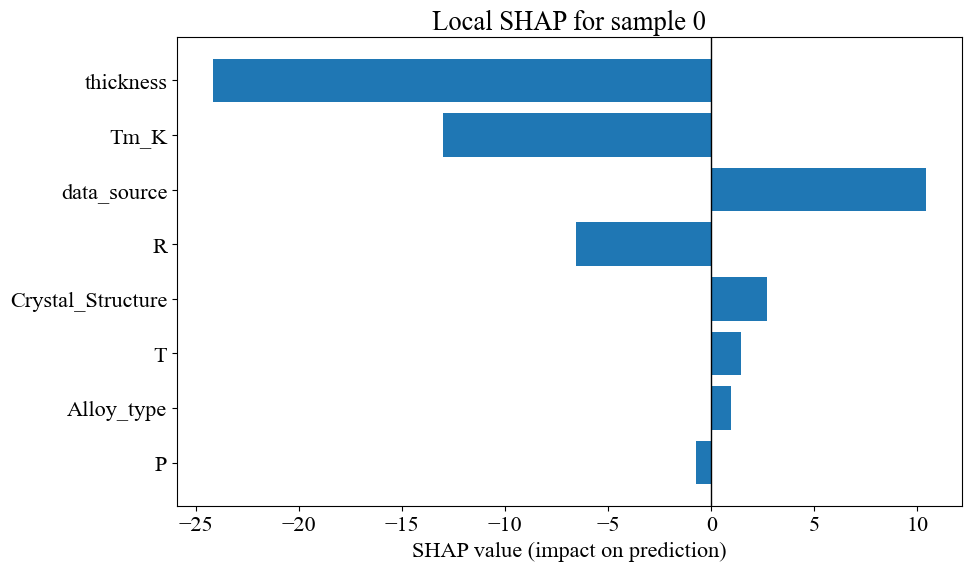

In [202]:
local_contribs = {}
idx = 0

# numeric features: one column each
for f in num_features:
    local_contribs[f] = shap_vals_example[idx]
    idx += 1

# categorical features: sum over all one-hot columns per original feature
for orig, cats in zip(cat_features, ohe.categories_):
    n_cols = len(cats)
    local_contribs[orig] = shap_vals_example[idx:idx + n_cols].sum()
    idx += n_cols

# now local_contribs has one SHAP value per original feature
names = np.array(list(local_contribs.keys()))
vals  = np.array(list(local_contribs.values()))

top_idx = np.argsort(np.abs(vals))[-10:][::-1]
top_names = names[top_idx]
top_vals  = vals[top_idx]

plt.figure(figsize=(10, 6))
plt.barh(top_names, top_vals)
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("SHAP value (impact on prediction)")
plt.title(f"Local SHAP for sample {example_idx}")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("figures/local_shap_example_grouped.png", dpi=300)
plt.show()
